The AB test is a randomized experiment that is used by most large companies to evaluate the launch of new functionality. Various difficulties may arise in the analysis and conduct of the experiment. Several typical problematic cases from real life are given in this dataset and analysis.

### Content
1. [Loading and processing data](#Loading)
2. [Statistical Analysis](#Statistical)
3. [Conclusions](#Conclusions)

### Loading and processing data <a name="Loading"/>

Let's import the necessary libraries and load the data

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro

In [2]:
# TODO : import the dataset
df = pd.read_csv('AB_Test_Results.csv')

In [3]:
# TODO : take a quick look at the data

print(df.head())
df.info()

   USER_ID VARIANT_NAME  REVENUE
0      737      variant      0.0
1     2423      control      0.0
2     9411      control      0.0
3     7311      control      0.0
4     6174      variant      0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


Let's see if there are users who have two A/B test groups

In [25]:
# TODO : Look at the distribution of the number of unique groups for each user

grouped_users = df.groupby('USER_ID')['VARIANT_NAME'].nunique().reset_index()

VARIANT_NAME
1    0.756325
2    0.243675
Name: proportion, dtype: float64


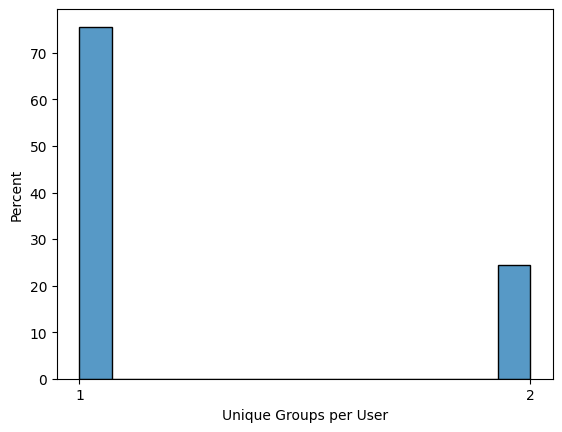

In [23]:
# TODO : Look at the distribution of the number of unique groups for each user in relative terms

# Distribution in relative terms
relative_distribution = df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts(normalize=True)
print(f"{relative_distribution}")

# Plot distribution
sns.histplot(data=grouped_users, x='VARIANT_NAME', stat='percent')
plt.xticks(range(1, grouped_users['VARIANT_NAME'].max() + 1))
plt.xlabel("Unique Groups per User")
plt.show()


**What can you observe ? Should we exclude these users ? Why ?**

24% of our users are in more than one group, we should exclude those users as it would be hard for us to attribute any behavior to a specific variant causing bias on our test results

In [33]:
# TODO : users have 1 A/B test group ?
# TODO : Take only these users
# Filter users that only belong to 1 A/B test group
users_one_group = grouped_users.loc[grouped_users['VARIANT_NAME'] == 1, 'USER_ID']

VARIANT_NAME
1    1.0
Name: proportion, dtype: float64


,USER_ID
VARIANT_NAME,
control,3026
variant,3044


In [35]:
# TODO : Leave only records with users with the 1st ab test group
filtered_df = df[df['USER_ID'].isin(users_one_group)]

# Check distribution again
grouped_filtered = filtered_df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts(normalize=True)
print(grouped_filtered)

# TODO : Check that the number of users matches what it was before the exception
# Check how many unique users are in each group
print(f"\nBefore Exception:")
print(df.groupby('VARIANT_NAME')['USER_ID'].count())
print(f"\nAfter Exception:")
print(filtered_df.groupby('VARIANT_NAME')['USER_ID'].count())


VARIANT_NAME
1    1.0
Name: proportion, dtype: float64

Before Exception:
VARIANT_NAME
control    4984
variant    5016
Name: USER_ID, dtype: int64

After Exception:
VARIANT_NAME
control    3026
variant    3044
Name: USER_ID, dtype: int64


Let's see how the data is distributed

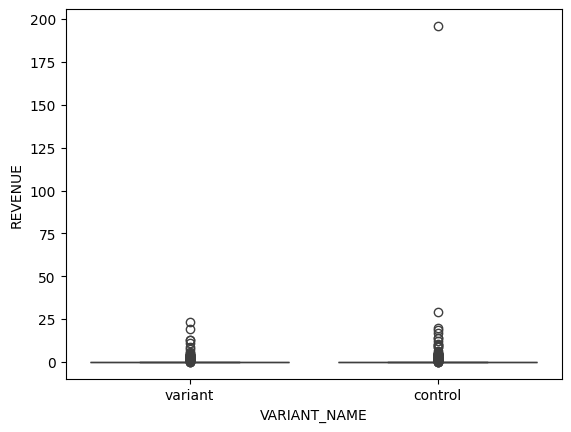

In [37]:
# TODO : Check how the data is distributed using a box plot

sns.boxplot(data=filtered_df, x='VARIANT_NAME', y='REVENUE')
plt.show()


It can be seen that there is a strong outlier in the data - we will find it by sorting these revenue values in descending order

In [38]:
# TODO : Sort these revenue values in descending order

filtered_df = filtered_df.sort_values(by='REVENUE', ascending=False)
filtered_df

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47
...,...,...,...
3400,9003,variant,0.00
3401,9902,variant,0.00
3403,4863,control,0.00
3404,1807,control,0.00


In [41]:
# TODO : See if user 3342 had other events with a strong outlier

condition = filtered_df['USER_ID'] == 3342

filtered_df[condition]

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01


We see that there is only one outlier - in conditions of limited information, we will remove this entry and look at the distribution of data again

In [44]:
# TODO : We see that there is only one outlier - in conditions of limited information, remove this entry and visualize the distribution of data again.

filtered_df = filtered_df[~condition]

# Check if outlier still there
filtered_df[condition]

/tmp/ipython-input-2737316448.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = filtered_df[~condition]
/tmp/ipython-input-2737316448.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df[condition]


,USER_ID,VARIANT_NAME,REVENUE
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47
5530,282,control,18.56
...,...,...,...
26,3614,variant,0.00
24,4772,variant,0.00
23,425,variant,0.00
22,6226,variant,0.00


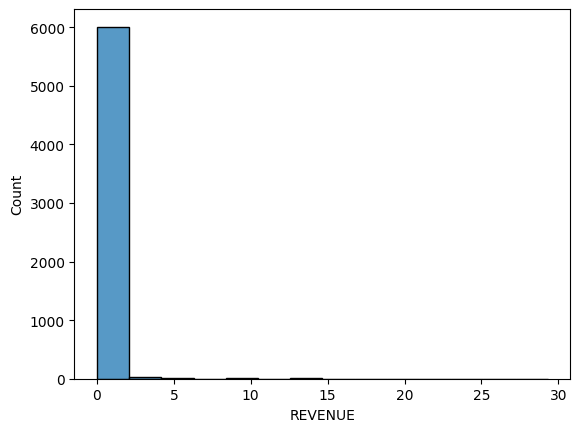

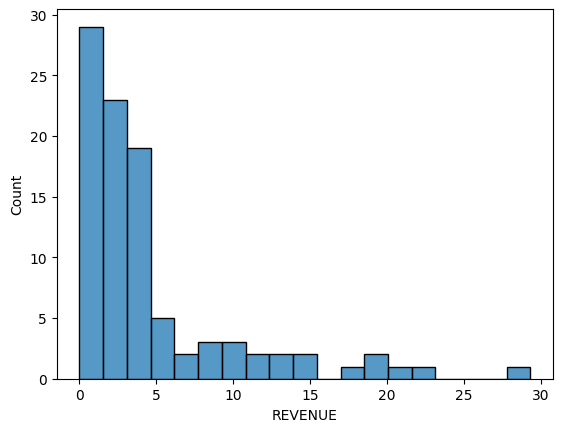

In [50]:
# Check distribution of revenue (all users)
sns.histplot(data=filtered_df, x='REVENUE')
plt.show()

# Check distribution of revenue for payers
payers = filtered_df.loc[filtered_df['REVENUE'] > 0]
sns.histplot(data=payers, x='REVENUE')
plt.show()

<Axes: xlabel='VARIANT_NAME'>

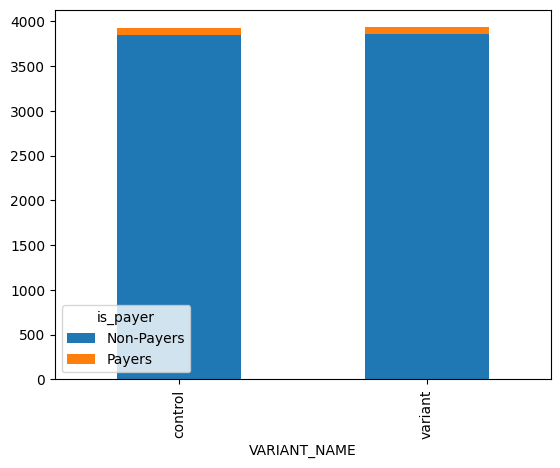

In [57]:
# Check number of users who paid vs number of users who didn't pay

# Aggregate to user level
user_level = (
    df.groupby(['USER_ID', 'VARIANT_NAME'])['REVENUE']
    .sum()
    .reset_index()
)

# Create flag (new column)
user_level['is_payer'] = user_level['REVENUE'] > 0

# Count payers/non payers per variant
counts = user_level.groupby(['VARIANT_NAME', 'is_payer'])['USER_ID'].count().unstack(fill_value=0)

# Visualize payers/non payers per variant
counts.rename(columns={False: 'Non-Payers', True: 'Payers'}).plot(kind='bar', stacked=True)

In [65]:
# Check percentage of payer vs non payers per variant

payer_non_payer_percentages = (
    user_level.groupby('VARIANT_NAME')['is_payer']
    .value_counts(normalize=True)
    .rename('percentage')
    .mul(100)
    .reset_index()
)

payer_non_payer_percentages.rename

,VARIANT_NAME,is_payer,percentage
0,control,False,97.964894
1,control,True,2.035106
2,variant,False,98.195221
3,variant,True,1.804779


In [51]:
filtered_df.describe()

,USER_ID,REVENUE
count,6069.000000,6069.000000
mean,4983.934586,0.074785
std,2898.152264,0.907245
min,2.000000,0.000000
25%,2472.000000,0.000000
50%,4951.000000,0.000000
75%,7501.000000,0.000000
max,9998.000000,29.320000



What can you say about the users and their purchases ?

We have many datapoints at 0 for revenue (75% of our datapoints fall at the value 0 which is huge) - we have some payers but most of our data is around the non-payers.

As well, we can see that we have around 98% of our users that are non payers on both variants. This shows an extremely low conversion rate even if the variant at first sight shows a small increase in payers.

In [78]:
# TODO : Check if there are users who have records with zero and positive revenue

min_max = filtered_df.groupby('USER_ID')['REVENUE'].agg(['min', 'max', 'count'])

zero_and_positive_revenue = min_max[(min_max['min'] == 0) & (min_max['max'] != 0)].reset_index()

print(f"Users with both 0 and positive revenue: {zero_and_positive_revenue.shape[0]}")

Users with both 0 and positive revenue: 37


Can a user have records with both zero and positive revenue ?

Let's make the assumption that the records are user visits to the service, and the experimental unit is users.

Yes, a user can have records with both zero and positive revenue. It could be that on one visit to the service they purchased and on another visit they didn't end up purchasing.

In [82]:
# TODO : Group the data for each user and sum the revenue for each to get one record per user

total_revenue_per_user = filtered_df.groupby('USER_ID')['REVENUE'].sum().reset_index()

total_revenue_per_user

,USER_ID,REVENUE
0,2,0.0
1,4,0.0
2,5,0.0
3,6,0.0
4,9,0.0
...,...,...
4777,9990,0.0
4778,9992,0.0
4779,9993,0.0
4780,9995,0.0


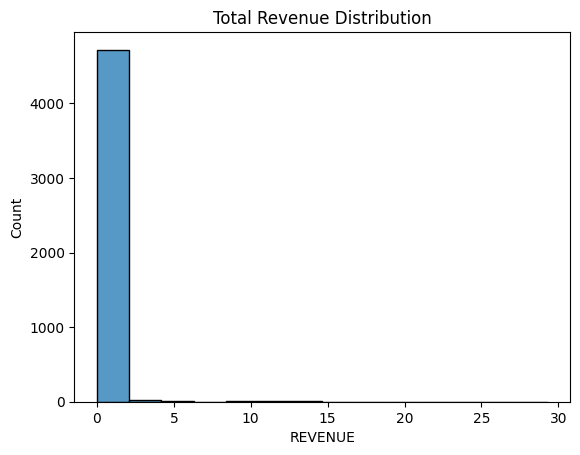

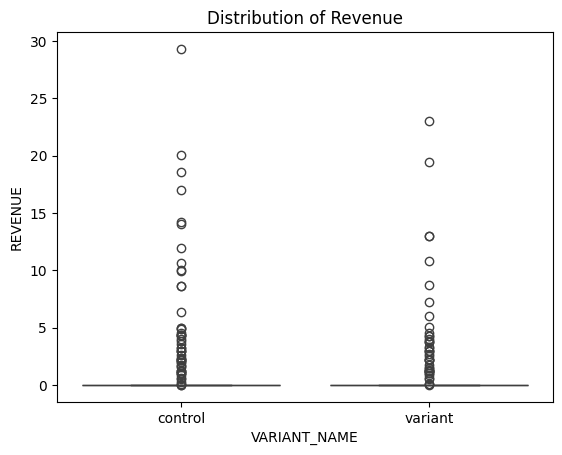

In [84]:
# TODO : Visualize the resulting distribution of the data again.

# Showing revenue distribution of total revenue
sns.histplot(data=total_revenue_per_user, x='REVENUE')
plt.title("Total Revenue Distribution")
plt.show()

# Showing distribution using boxplot after removing outlier
sns.boxplot(data=filtered_df, x='VARIANT_NAME', y='REVENUE')
plt.title('Distribution of Revenue')
plt.show()

It should be noted that during the transformation, the quantiles in the test group increased

It can be seen that in the test group, almost all quantile statistics, except for the minimum, are at a slightly lower level.

Let's look at various statistics in the context of AB test groups for all users

In [92]:
# TODO : get metrics by groups

# MEAN & MEDIAN
control_mean = filtered_df.loc[filtered_df['VARIANT_NAME'] == 'control', 'REVENUE'].mean()
variant_mean = filtered_df.loc[filtered_df['VARIANT_NAME'] == 'variant', 'REVENUE'].mean()

control_median = filtered_df.loc[filtered_df['VARIANT_NAME'] == 'control', 'REVENUE'].median()
variant_median = filtered_df.loc[filtered_df['VARIANT_NAME'] == 'variant', 'REVENUE'].median()

# TODO : create two additional metrics to see relative changes
abs_change_mean = variant_mean - control_mean
rel_change_mean = (variant_mean - control_mean) / control_mean * 100

# TODO : add them to the rest of the metrics in a separate group
metrics = pd.DataFrame({
    'Metric': ['Mean'],
    'Control': [control_mean],
    'Variant': [variant_mean],
    'Abs_Change': [abs_change_mean],
    'Rel_Change': [rel_change_mean]
})

metrics

,Metric,Control,Variant,Abs_Change,Rel_Change
0,Mean,0.09076,0.058909,-0.031851,-35.093527


What can you see in the test group about the total amount of revenue, the average check per user, and the number of orders per user slightly increased ?

Let's also see how paying users behave :

In [95]:
# Separate groups into control and variant
control_group = filtered_df[filtered_df['VARIANT_NAME'] == 'control']
variant_group = filtered_df[filtered_df['VARIANT_NAME'] == 'variant']

# TODO : get metrics by groups
control_total_revenue = control_group['REVENUE'].sum()
variant_total_revenue = variant_group['REVENUE'].sum()

control_avg_check = control_group.groupby('USER_ID')['VARIANT_NAME'].count().mean()
variant_avg_check = variant_group.groupby('USER_ID')['VARIANT_NAME'].count().mean()

# TODO : create two additional metrics to see relative changes
total_revenue_abs_change = variant_total_revenue - control_total_revenue
total_revenue_rel_change = (variant_total_revenue - control_total_revenue) / control_total_revenue * 100

avg_check_abs_change = variant_avg_check - control_avg_check
avg_check_rel_change = (variant_avg_check - control_avg_check) / control_avg_check * 100

# TODO : add them to the rest of the metrics in a separate group
new_rows = [['Total Revenue', control_total_revenue, variant_total_revenue, total_revenue_abs_change, total_revenue_rel_change], ['Average Check', control_avg_check, variant_avg_check, avg_check_abs_change, avg_check_rel_change]]

for row in new_rows:
  metrics.loc[len(metrics)] = row

metrics


,Metric,Control,Variant,Abs_Change,Rel_Change
0,Mean,0.09076,0.058909,-0.031851,-35.093527
1,Total Revenue,274.55000,179.320000,-95.230000,-34.685850
2,Average Check,1.26622,1.272043,0.005823,0.459895


Let's look at the distributions of all and only paying users

/tmp/ipython-input-4101851425.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
/tmp/ipython-input-4101851425.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'

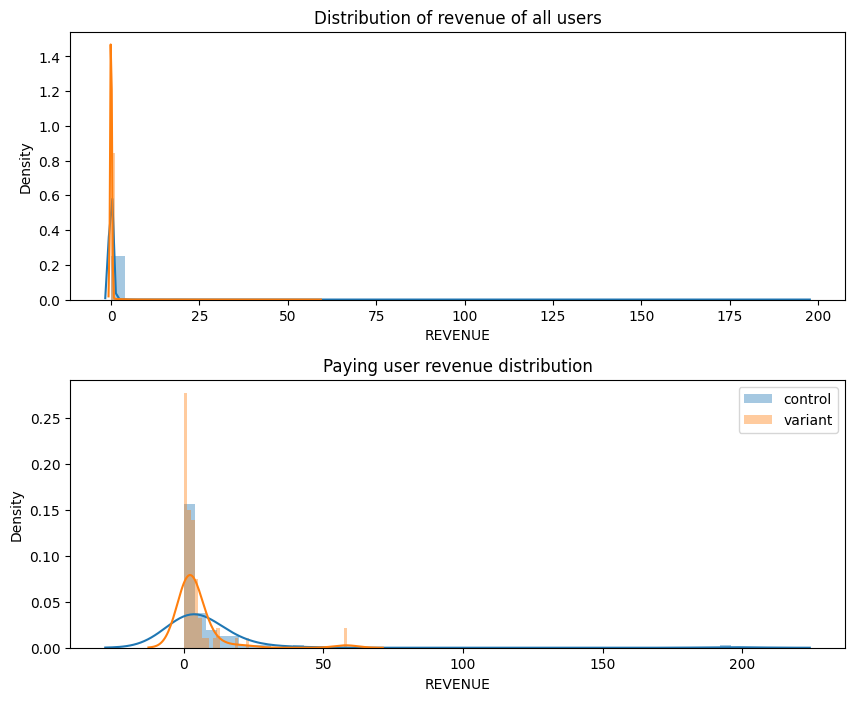

In [96]:
f, axes = plt.subplots(2, figsize=(10,8))
# build graphs of distributions of all users
sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'], ax = axes[0], label='variant')
axes[0].set_title('Distribution of revenue of all users')

# build graphs of distributions of paying users
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='control' )
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='variant' )
axes[1].set_title('Paying user revenue distribution')
plt.legend()
plt.subplots_adjust(hspace = 0.3)

### Statistical Analysis <a name="Statistical"/>

#### Checking if the distribution is normal

Based on their previous graph, we see that the data is not normally distributed.

In [98]:
# TODO : Use the Shapiro-Wilk criterion to confirm it
# Null hypothesis of the Shapiro-Wil test -> data comes from a normally distributed population

# Control group
control_revenue = control_group['REVENUE']
stat_c, p_c = shapiro(control_revenue)
print(f"Control Group -> Statistic: {stat_c:.3f}, p-value: {p_c:.3f}")

# Variant group
variant_revenue = variant_group['REVENUE']
stat_v, p_v = shapiro(variant_revenue)
print(f"Variant Group -> Statistic: {stat_v:.3f}, p-value: {p_v:.3f}\n")

# Interpret results
# Control
if p_c > 0.05:
  print("Failed to reject null hypothesis - Control Revenue is normally distributed")
else:
  print("Reject Null Hypothesis - Control Revenue is NOT normally distributed")

if p_v > 0.05:
  print("Failed to reject null hypothesis - Variant Revenue is normally distributed")
else:
  print("Reject Null Hypothesis - Variant Revenue is NOT normally distributed")




Control Group -> Statistic: 0.062, p-value: 0.000
Variant Group -> Statistic: 0.051, p-value: 0.000

Reject Null Hypothesis - Control Revenue is NOT normally distributed
Reject Null Hypothesis - Variant Revenue is NOT normally distributed


Is the null hypothesis about the normal distribution of the data rejected ?

Yes, we got a p-value of 0.000 for both, meaning we reject the null hypothesis. We see that both variants are not normally distributed.

#### Mann-Whitney test

Let's check the value of the statistics of the Mann-Whitney test. Some sources have a limitation of applicability in case of duplicate data. There are a lot of repetitions in our sample, and especially a lot of zero values, so in this case we need to be careful about this criterion.

In [99]:
(df['REVENUE'] == 0).value_counts()

,count
REVENUE,
True,9848
False,152


In [101]:
# TODO : Check on the data of all users the value of the statistics of the Mann-Whitney test
# Null hypothesis - Control and variant revenue are the same, variant didn't improve revenue

# Run the Mann-Whitney U test
stat, p_value = mannwhitneyu(control_revenue, variant_revenue, alternative='two-sided')

print(f"Mann Whitney U statistic: {stat:.3f}, p-value: {p_value:.3f}\n")

# Interpret results
if p_value < 0.05:
  print("Reject Null Hypothesis. There's statistically significant evidence that the variant improved revenue")
else:
  print("Failed to reject null hypothesis. There is no statistically significant evidence that the variant improves revenue compared to control")


Mann Whitney U statistic: 4619788.000, p-value: 0.286

Failed to reject null hypothesis. There is no statistically significant evidence that the variant improves revenue compared to control


In [67]:
# TODO : Check on the data of only the users that pay, the value of the statistics of the Mann-Whitney test

# Get revenue values for control and variant payers 
control_payers = control_group.loc[control_group['REVENUE'] > 0, 'REVENUE']
variant_payers = variant_group.loc[variant_group['REVENUE'] > 0, 'REVENUE']

# Run Mann-Whitney U test
stat, p_value = mannwhitneyu(control_payers, variant_payers, alternative='two-sided')
print(f"Mann Whitney U statistic: {stat:.3f}, p-value: {p_value:.3f}\n")

if p_value < 0.05:
    print("Reject Null Hypothesis. There's statistically significant evidence that the mean of variant and control payer groups differ")
else:
    print("Failed to reject null hypothesis. There's no statistically significant evidence that the mean of variant and control payer groups differ.")



Mann Whitney U statistic: 1249.000, p-value: 0.422

Failed to reject null hypothesis. There's no statistically significant evidence that the mean of variant and control payer groups differ.


#### Bootstrap

In order to get more complete information about the differences between the average values of the ab test groups, we will use bootstap.

Let's create a function to get back samples and get a confidence interval, and then look at the sample statistics

**Explanation of why we're using bootstrap after Mann Whitney U Test**

The Mann-Whitney U test tells you whether there's a significant difference, but it doesn't tell you how large that difference is or how confident you should be in the estimate. Bootstrap fills that gap by:

1. Repeatedly resampling your data (with replacement) from each group
2. Calculating the mean for each resample
3. Building a distribution of possible means to show the range of plausible values

It gives you a confidence interval around your estimate—essentially saying "the true mean is likely somewhere in this range."

Important to know: You run bootstrap only if Mann Whitney U test shows that there's a significant difference (you reject the null hypothesis)

In [102]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [106]:
# TODO : Generate samples for all users
control_samples = get_bootstrap_samples(control_revenue.values, n_samples=1000)
variant_samples = get_bootstrap_samples(variant_revenue.values, n_samples=1000)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [111]:
# TODO : Generate samples for only paying users

# Filter payers users per variant
control_payers = filtered_df.loc[(filtered_df['REVENUE'] > 0) & (filtered_df['VARIANT_NAME'] == 'control'), 'REVENUE']
variant_payers = filtered_df.loc[(filtered_df['REVENUE'] > 0) & (filtered_df['VARIANT_NAME'] == 'variant'), 'REVENUE']

# Generate samples for only paying users
control_payers_samples = get_bootstrap_samples(control_payers.values, n_samples=1000)
variant_payers_samples = get_bootstrap_samples(control_payers.values, n_samples=1000)

Let's look at the distribution of means in the ab test groups

/tmp/ipython-input-2403277890.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(control_samples, axis=1), shade=True, label='control')
/tmp/ipython-input-2403277890.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(variant_samples, axis=1), shade=True, label='variant')


Text(0.5, 1.0, 'Sample mean distribution for all users')

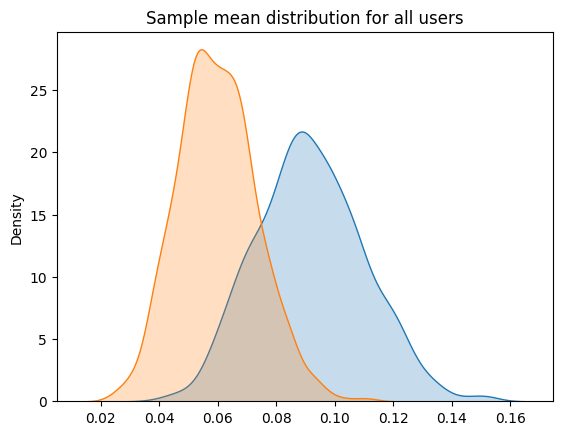

In [112]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control_samples, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant_samples, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for all users')

/tmp/ipython-input-2950188207.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(control_payers_samples, axis=1), shade=True, label='control')
/tmp/ipython-input-2950188207.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(variant_payers_samples, axis=1), shade=True, label='variant')


Text(0.5, 1.0, 'Sample mean distribution for paying users')

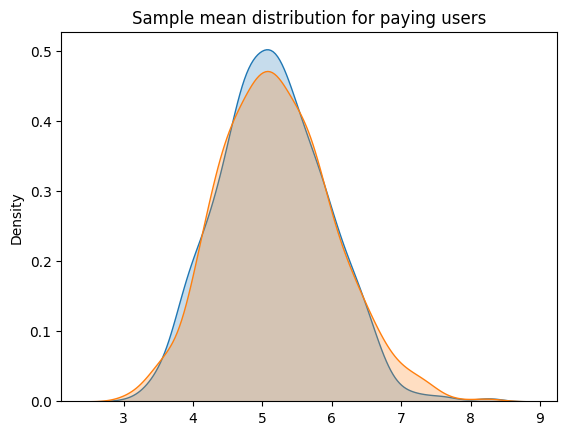

In [113]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control_payers_samples, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant_payers_samples, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for paying users')

Do you see any difference ? What about the confidence intervals ? Conclude.

Let's evaluate the difference between the groups: look at the distribution of the mean difference and build confidence intervals for it. To do this, we will create a function for visualization

In [114]:
def plot_distribution_and_stat_intervals(variant, control, title, alpha=0.05):
    """ Plot the distribution of the mean difference and return the confidence intervals """
    from scipy import stats

    f, ax = plt.subplots()

    # Calculate the difference
    diff = variant - control

    # Manually compute KDE
    kde = stats.gaussian_kde(diff)
    x = np.linspace(diff.min(), diff.max(), 1000)
    y = kde(x)

    # Plot the KDE
    ax.plot(x, y)
    ax.fill_between(x, y, alpha=0.3)

    ymin, ymax = plt.ylim()

    # Calculate confidence intervals
    ci = stat_intervals(diff, alpha)

    # highlight the zero value and the bounds of the confidence interval
    plt.vlines(0, 0, ymax, label='0', color='gray', linewidth=2)
    plt.vlines(ci[0], 0, ymax, linestyles="dashed", linewidth=2)
    plt.vlines(ci[1], 0, ymax, linestyles="dashed", linewidth=2)

    # color the confidence interval and zones outside it
    plt.fill_between(x, y,
                     where=(x >= ci[1]),
                     color='gainsboro',
                     alpha=0.5)
    plt.fill_between(x, y,
                     where=(x <= ci[0]),
                     color='gainsboro',
                     alpha=0.5)
    plt.fill_between(x, y,
                     where=((x >= ci[0]) & (x <= ci[1])),
                     color='red',
                     alpha=0.5,
                     label='95% confidence interval')

    plt.xlabel('Difference in Means (Variant - Control)')
    plt.ylabel('Density')
    plt.title(f'Distribution of difference between means (variant - control) {title};\n{100*(1-alpha)}% Confidence interval: {ci}')
    plt.legend(prop={'size': 13})

    # return confidence interval data
    return ci

Let's build a graph of the distribution of the difference in the means and get a confidence interval

For all users

array([-0.07439223,  0.01152291])

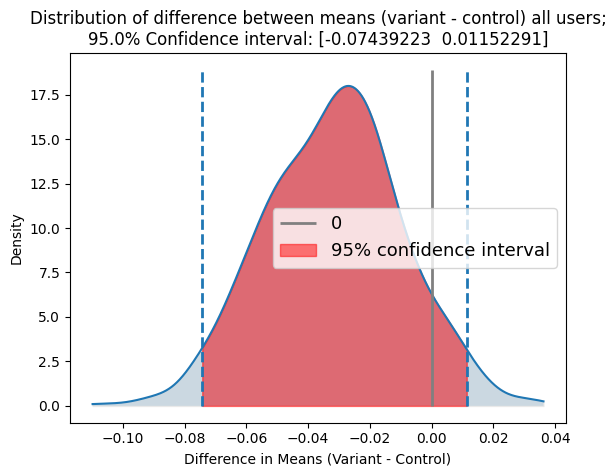

In [115]:
plot_distribution_and_stat_intervals(np.mean(variant_samples, axis=1),
                                     np.mean(control_samples, axis=1),
                                     title='all users')

The confidence interval is `[0.0743, 0.0115]` and we have 0 inside the interval.

This means we're 95% confident the true difference in means between control and variant for all users revenue is somewhere between -0.0743 and 0.0115. Since zero falls within this range we can't say with confidence the variant is better or worse than control.

array([-2.11158491,  2.30944811])

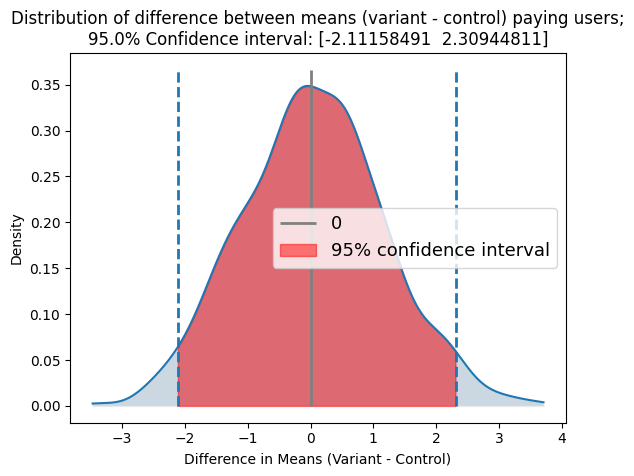

In [116]:
plot_distribution_and_stat_intervals(np.mean(variant_payers_samples, axis=1),
                                     np.mean(control_payers_samples, axis=1),
                                     title='paying users')

The confidence interval is `[-2.1158, 2.3094]` and zero is inside this interval as well.

Among paying customers, the variant could be anywhere from `$2.12` worse to `$2.31` better than control. High uncertainty.

What can you observe ? Conclude about the statistical change in average revenue between A/B test groups.

For all users, the variant does not significantly improve revenue.

Among payers, there's also no meaningful difference in spending between variant and control.

I'd recommend not to implement this variant and to work on a different strategy to increase average revenue per user.